In [1]:
import numpy as np 
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
%matplotlib inline

# Data Load and Analysis
### Imagewoof dataset is available on https://github.com/fastai/imagenette . 

 `print(imagewoof_info)` gives following Information regarding the dataset:

*   `image.shape` -> (shape=(None, None, 3) we recognize that the images contained in the dataset have different sizes
*   By num_classes=10 we know that all images belong to 10 classes, or categories
*   total_num_examples=12954 indicates the number of images
*   Also, the images are already divided into "train" and "validation" and contain 9025 and 3929 images, respectively.


In [2]:
# Connect Google Colab with Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=12954,
    splits={
        'train': 9025,
        'val': 3929,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)

(256, 320, 3) 0
(348, 370, 3) 3
(500, 483, 3) 9
(467, 700, 3) 0
Train
9025


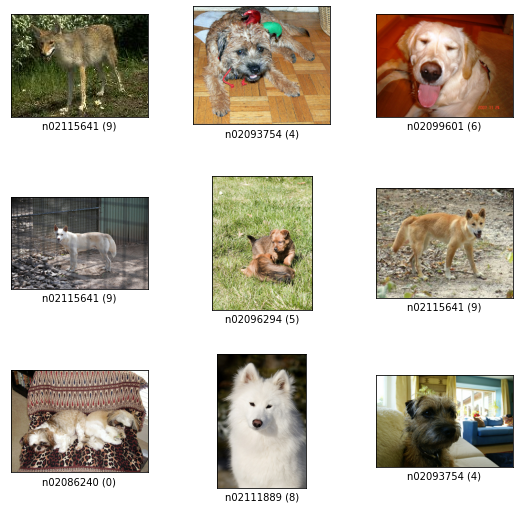

Test
3929


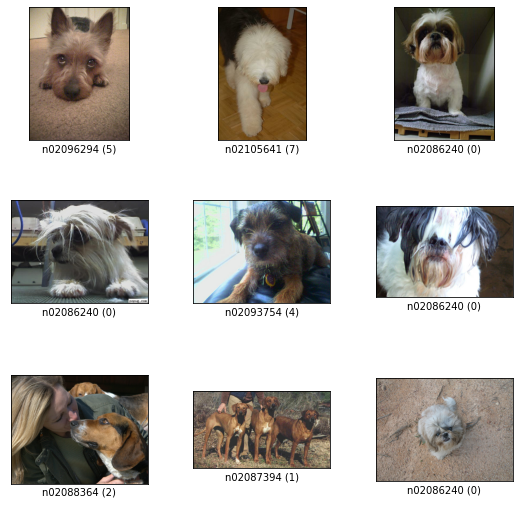

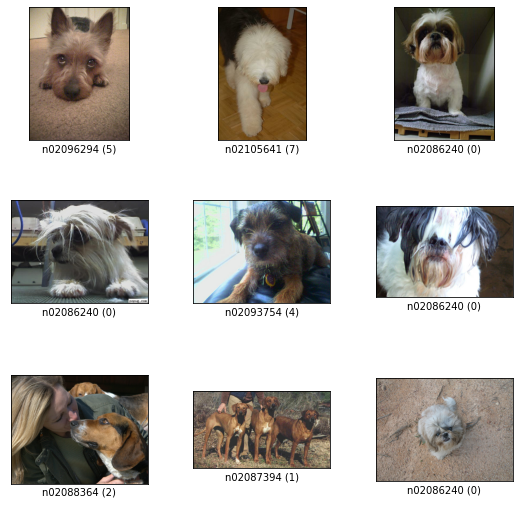

In [3]:
# reference :- https://www.tensorflow.org/datasets/overview
batch_size = 128
#imagenette_builder = tfds.builder("imagewoof/full-size-v2")

data_dir = '/content/gdrive/MyDrive/Colab_Notebooks/CVDL_Project/imagewoof2'
imagewoof_builder = tfds.ImageFolder(data_dir) # ImageFolder creates a tf.data.Dataset reading the original image files.
'''print(imagenette_builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='train',as_supervised=True, shuffle_files=True)
tfds.show_examples(ds, builder.info)'''


imagewoof_info = imagewoof_builder.info
print(imagewoof_info)

#imagenette_builder.download_and_prepare()
datasets = imagewoof_builder.as_dataset(as_supervised=True,shuffle_files=True)
(train_datasets,test_datasets)=imagewoof_builder.as_dataset(split=['train', 'val'],as_supervised=True, shuffle_files=True)
train_examples = imagewoof_info.splits['train'].num_examples
validation_examples = imagewoof_info.splits['val'].num_examples


ds= train_datasets.take(4)  # Only take a few example
for image, label in ds:  # example is (image, label)
  print(image.shape, tfds.as_numpy(label))


print("Train")
print(train_examples)
tfds.show_examples(train_datasets, imagewoof_builder.info)

print("Test")
print(validation_examples)
tfds.show_examples(test_datasets, imagewoof_builder.info)


,image,label
0,,6 (n02099601)
1,,5 (n02096294)
2,,4 (n02093754)
3,,9 (n02115641)

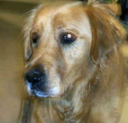
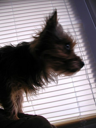
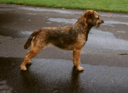
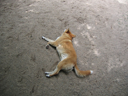

In [4]:
tfds.as_dataframe(train_datasets.take(4), imagewoof_builder.info)

In [5]:
info = imagewoof_builder.info
print(info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


Finally, there are 10 classes to which the images are assigned.  `print(info.features['label'].names)` goves this information.
Look into the images and determine the class label .

https://github.com/fastai/imagenette shows Imagenet classes are (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

In [6]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(1))  # Human readable version (1 -> 'n02087394'->'gas pump')
print(info.features["label"].str2int('n02087394'))
class_labels = [0,1,2,3,4,5,6,7,8,9] 
lbl_dict = dict(
  n02093754='Australian terrier', 
  n02089973='Border terrier', 
  n02099601='Samoyed', 
  n02087394='Beagle', 
  n02105641='Shih-Tzu', 
  n02096294='English foxhound', 
  n02088364='Rhodesian ridgeback', 
  n02115641='Dingo', 
  n02111889='Golden retriever', 
  n02086240='Old English sheepdog'
)

for i, value in lbl_dict.items():
  index=info.features["label"].str2int(i)
  print(index, value)
  class_labels[index]=value

print(class_labels) 

10
['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']
n02087394
1
4 Australian terrier
3 Border terrier
6 Samoyed
1 Beagle
7 Shih-Tzu
5 English foxhound
2 Rhodesian ridgeback
9 Dingo
8 Golden retriever
0 Old English sheepdog
['Old English sheepdog', 'Beagle', 'Rhodesian ridgeback', 'Border terrier', 'Australian terrier', 'English foxhound', 'Samoyed', 'Shih-Tzu', 'Golden retriever', 'Dingo']


In [7]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

{'image': (None, None, 3), 'label': (), 'image/filename': ()}
{'image': tf.uint8, 'label': tf.int64, 'image/filename': tf.string}
(None, None, 3)
<dtype: 'uint8'>


In [8]:
print(info.splits)
print(list(info.splits.keys()))

{'train': <tfds.core.SplitInfo num_examples=9025>, 'val': <tfds.core.SplitInfo num_examples=3929>}
['train', 'val']


# Preprocessing steps

1.   Resize all the images (128,128, 3)
2.   Normalize pixel values of each image so that they are all in a   range between 0 and 1. Normally the value of a pixel is between 0 and 255 (RGB color values), but the neural networks prefer to calculate with values between 0 and 1, so we will simply divide each pixel value by 255.




In [9]:
size_image = 224
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(size_image, size_image,crop_to_aspect_ratio=True),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
]) 

In [10]:
train_datasets = train_datasets.map(
  lambda image,label: (resize_and_rescale(image, training=True),label)) 

In [11]:
test_datasets = test_datasets.map(
  lambda image, label: (resize_and_rescale(image, training=False), label)) 

In [12]:
for img, label in train_datasets.take(5):
  print(img.shape,label) 

(224, 224, 3) tf.Tensor(3, shape=(), dtype=int64)
(224, 224, 3) tf.Tensor(2, shape=(), dtype=int64)
(224, 224, 3) tf.Tensor(1, shape=(), dtype=int64)
(224, 224, 3) tf.Tensor(9, shape=(), dtype=int64)
(224, 224, 3) tf.Tensor(5, shape=(), dtype=int64)


In [13]:
def plot_images(data, size=(20,20)):
  plt.figure(figsize=size)
  for i in range(25):
    for img, label in data.take(i+1):
      plt.subplot(5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(True)
      plt.imshow(img, cmap=plt.cm.binary)
      plt.title(class_labels[label])
      plt.ylabel(img.shape)
  plt.show() 

In [14]:
plot_images(train_datasets) 

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# define data preparation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:

train_datasets = train_datasets.map(
  lambda image,label: (data_augmentation(image,training=True),label)) 

In [17]:
plot_images(train_datasets)

Output hidden; open in https://colab.research.google.com to view.

# Model

In [18]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding='same', activation=tf.keras.layers.ReLU(),input_shape=(size_image,size_image,3)),
    tf.keras.layers.Conv2D(32,(3,3),padding='same', activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(128,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(128,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(128,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(256,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(256,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(256,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Conv2D(512,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation=tf.keras.layers.ReLU()),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10,activation='softmax')]) 

In [19]:
model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)     

In [20]:
train_batch = train_datasets.batch(64)

test_batch = test_datasets.batch(64) 

In [21]:
for img, label in train_batch.take(5):
  print(img.shape,label) 

(64, 224, 224, 3) tf.Tensor(
[9 7 9 1 8 4 0 2 7 1 4 5 1 2 5 9 9 7 2 1 5 6 6 5 1 6 7 4 2 0 7 6 1 0 3 6 6
 7 6 2 2 9 8 3 3 1 5 2 1 0 1 8 1 5 4 8 7 3 5 9 9 0 8 3], shape=(64,), dtype=int64)
(64, 224, 224, 3) tf.Tensor(
[2 6 2 7 0 8 1 7 3 2 4 2 9 6 9 8 9 0 0 6 3 9 7 1 4 5 0 0 5 8 8 5 5 8 5 2 1
 5 3 0 9 0 2 0 7 1 1 3 3 8 2 2 5 7 4 9 8 0 0 5 4 8 3 8], shape=(64,), dtype=int64)
(64, 224, 224, 3) tf.Tensor(
[2 5 9 6 6 2 0 7 8 4 2 4 4 0 7 2 9 9 1 7 1 8 5 0 4 6 6 6 2 4 2 0 1 0 7 4 6
 8 5 3 9 4 6 0 4 2 9 0 1 7 5 0 2 1 9 5 4 7 2 2 6 2 1 3], shape=(64,), dtype=int64)
(64, 224, 224, 3) tf.Tensor(
[0 3 5 3 3 1 0 2 2 8 8 1 1 1 1 4 0 6 2 7 4 0 0 8 1 2 2 9 6 8 6 7 0 6 0 7 5
 5 6 4 3 1 6 1 3 7 7 5 2 9 5 0 8 0 6 7 0 4 2 1 7 9 5 1], shape=(64,), dtype=int64)
(64, 224, 224, 3) tf.Tensor(
[5 0 7 2 7 7 8 3 1 4 1 8 6 6 6 0 9 4 6 7 9 6 4 9 3 5 4 3 2 0 2 3 6 1 9 1 5
 2 6 2 6 1 8 3 5 4 4 5 2 0 7 6 6 7 9 1 7 9 7 4 8 2 6 5], shape=(64,), dtype=int64)


In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 


In [23]:
history = model.fit(train_batch,epochs=50,validation_data=test_batch,callbacks=[es]) 

Epoch 1/50
142/142 [==============================] - 601s 4s/step - loss: 2.3342 - accuracy: 0.1925 - val_loss: 2.4017 - val_accuracy: 0.1044
Epoch 2/50
142/142 [==============================] - 79s 560ms/step - loss: 2.0389 - accuracy: 0.2534 - val_loss: 3.4102 - val_accuracy: 0.1092
Epoch 3/50
142/142 [==============================] - 80s 562ms/step - loss: 1.8961 - accuracy: 0.3142 - val_loss: 4.6964 - val_accuracy: 0.1102
Epoch 4/50
142/142 [==============================] - 79s 557ms/step - loss: 1.7810 - accuracy: 0.3616 - val_loss: 2.2062 - val_accuracy: 0.2749
Epoch 5/50
142/142 [==============================] - 79s 558ms/step - loss: 1.7063 - accuracy: 0.3870 - val_loss: 2.4413 - val_accuracy: 0.2731
Epoch 6/50
142/142 [==============================] - 79s 555ms/step - loss: 1.6096 - accuracy: 0.4225 - val_loss: 2.9724 - val_accuracy: 0.1866
Epoch 7/50
142/142 [==============================] - 78s 551ms/step - loss: 1.5556 - accuracy: 0.4464 - val_loss: 1.8536 - val_accu

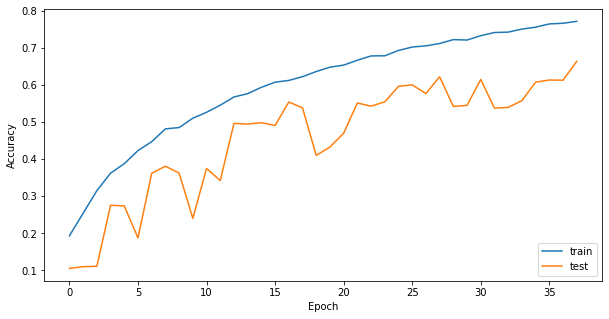

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right') 

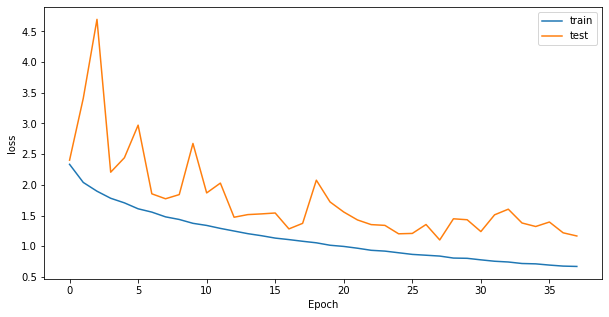

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right') 

In [26]:
test_acc = model.evaluate(test_batch, verbose=2)
print('Test accuracy: ',test_acc[1]) 
print('Test loss: ',test_acc[0])


62/62 - 9s - loss: 1.1666 - accuracy: 0.6633 - 9s/epoch - 150ms/step
Test accuracy:  0.6632730960845947
Test loss:  1.1665747165679932


In [27]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [28]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                100*np.max(predictions_array),
                                class_labels[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [29]:
labels =[]
labels_hat=[]
for image, label in test_batch:
  y_pred=model.predict(image)
  classes = np.argmax(y_pred,axis = 1)
  labels.extend(list(label.numpy()))
  labels_hat.extend(list(classes))

con_mat = tf.math.confusion_matrix(labels=labels, predictions=labels_hat).numpy()

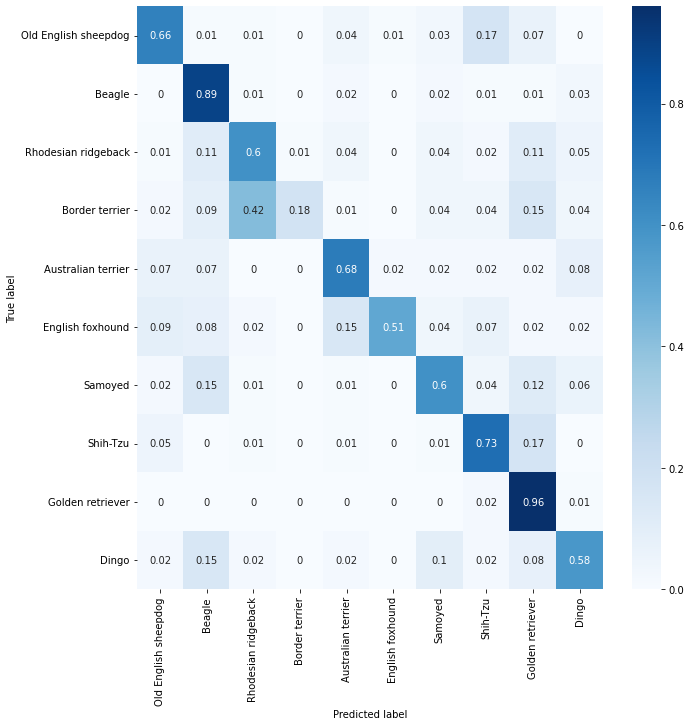

In [30]:
import pandas as pd
import seaborn as sns

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = class_labels, 
                     columns = class_labels)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
#reference:- https://www.tensorflow.org/tutorials/keras/classification
for test_images, test_labels in test_batch.take(5):  
  for l in range(len(label)):
    predictions = probability_model.predict(test_images)
    i = l
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i],  test_labels)
    plt.show()
  

Output hidden; open in https://colab.research.google.com to view.